In [1]:
%matplotlib inline

# import matplotlib
# matplotlib.use('Agg')

import numpy as np
from scipy.sparse import dok_matrix
import networkx as nx
from matplotlib import pyplot as plt
from itertools import permutations
from copy import copy
from tqdm import tqdm

In [2]:
import math
import random
from networkx.generators.classic import empty_graph

def kronecker_random_graph(k, P, seed=None, directed=True, n_edges=None):
    dim = len(P)
    
    errorstring = ("The initiator matrix must be a nonempty" +
                      (", symmetric," if not directed else "") +
                      " square matrix of probabilities.")

    if dim==0: 
        raise nx.NetworkXError(errorstring)
    for i,arr in enumerate(P): 
        if len(arr)!=dim: 
            raise nx.NetworkXError(errorstring)
        for j,p in enumerate(arr):
            if p<0 or p>1:
                raise nx.NetworkXError(errorstring)
            if not directed and P[i][j] != P[j][i]:
                raise nx.NetworkXError(errorstring)

    if k<1:
        return empty_graph(1)

    n = dim**k
    G = empty_graph(n)
    G=nx.DiGraph(G)

    acc = 0.0
    partitions = []
    for i in range(dim):
        for j in range(dim):
            if P[i][j] != 0:
                acc = acc+P[i][j]
                partitions.append([acc,i,j])
    psum = acc

    G.add_nodes_from(range(n))
    G.name="kronecker2_random_graph(%s,%s)"%(n, P)

    if not seed is None:
        random.seed(seed)
    
    if n_edges is None:
        expected_edges=math.floor(psum**k)
    else:
        expected_edges = n_edges
    num_edges = 0
    while num_edges<expected_edges:
        multiplier = dim**k
        x = y = 0
        for i in range(k):
            multiplier = multiplier // dim
            r = c = -1
            p = random.uniform(0,psum)
            for n in range(len(partitions)):
                if partitions[n][0] >= p:
                    r = partitions[n][1]
                    c = partitions[n][2]
                    break
            x = x + r*multiplier
            y = y + c*multiplier

        if not G.has_edge(x,y):
            G.add_edge(x,y)
            num_edges = num_edges + 1

    if not directed:
        G=G.to_undirected()

    return G

In [3]:
def gen_and_draw(P, k=8, n_edges=512):
    g = kronecker_random_graph(k, P, n_edges=n_edges, directed=False)
    nodes = max(nx.connected_components(g), key=len)
    g = g.subgraph(nodes)
        
    nx.draw(g, node_size=50)


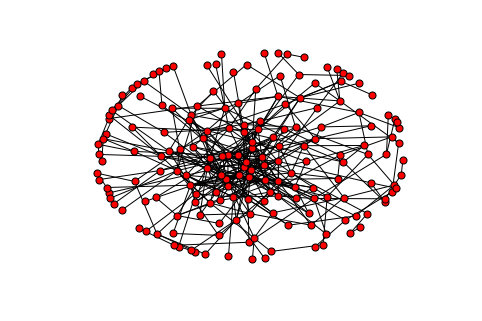

In [4]:
P = np.array([[0.9, 0.1], [0.1, 0.3]])  # core peripheral
gen_and_draw(P)

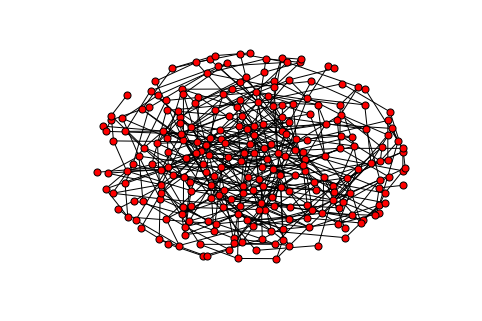

In [5]:
P = np.array([[0.5, 0.5], [0.5, 0.5]])  # random
gen_and_draw(P)

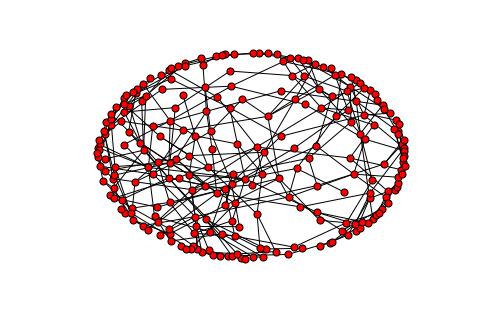

In [6]:
P = np.array([[0.9, 0.1], [0.1, 0.9]])  # hierarchical
gen_and_draw(P)

In [7]:
def generate_cascade(g):
    source = random.choice(g.nodes())
    infected = {source}
    infected_times = {source: 0}
    iter_n = 0
    while True:
        iter_n += 1    
        newly_infected = set()
        for u in infected:
            can_continue = False
            for v in g.neighbors(u):
                if v not in infected and not g[u][v].get('attempted', False):
                    # print('infected node: {}'.format(v))
                    can_continue = True
                    p_uv = 0.5  # proba of getting infected
                    if random.random() < p_uv:
                        newly_infected.add(v)
                        infected_times[v] = iter_n
                    g[u][v]['attempted'] = True
        infected |= newly_infected
        if not can_continue:
            break
    return infected_times

In [8]:
def build_random_walk_graph(g, infections):
    g = g.to_directed()
    for u, v in permutations(infections, 2):
        if g.has_edge(u, v) and infections[u] < infections[v]:
            g.remove_edge(u, v)
    return g

In [9]:
P_peri = np.array([[0.9, 0.1], [0.1, 0.3]])
P_heir = np.array([[0.9, 0.1], [0.1, 0.9]])
P_rand = np.array([[0.5, 0.5], [0.5, 0.5]])

In [10]:
def run_simulation(P, k, n_edges):
    g = kronecker_random_graph(k, P, directed=False, n_edges=n_edges)
    g = g.subgraph(max(nx.connected_components(g), key=len))

    infected_times = None
    for _ in range(10):
        infected_times = generate_cascade(g)
        if len(infected_times) > 10:
            break

    assert infected_times is not None

    percentage = 0.2
    source = min(infected_times, key=lambda k: infected_times[k])
    infected_minus_source = set(infected_times.keys()) - {source}

    observed = {n: infected_times[n]
                for n in random.sample(infected_minus_source,
                                       int(len(infected_minus_source) * percentage))}

    observed_original = copy(observed)
    # print('sampled {} from {}'.format(len(observed), len(infected_minus_source)))

    # actively querying
    iter_n = 0
    queries = []
    query = None
    while query != source:
        rw_g = build_random_walk_graph(g, observed)

        infected_nodes = set(observed.keys())
        earliest_node = sorted(observed, key=lambda k: observed[k])[0]
        personalization = {n: 0 for n in  rw_g.nodes_iter()}
        personalization[earliest_node] = 1
        # print('personalization ={}'.format(personalization))
        pr = nx.pagerank(rw_g, alpha=0.85,
                         personalization=personalization,
                         dangling=personalization,
                         nstart=personalization)
        query = max(filter(lambda n: n not in observed, pr), key=lambda k: pr[k])
        queries.append(query)
        observed[query] = infected_times.get(query, float('inf'))
        iter_n += 1

    return g, infected_times, observed_original, queries

In [11]:
g, infected_times, observed, queries = run_simulation(P_peri, 7, 256)
print('took {} queries to get to the source'.format(len(queries)))

took 1 queries to get to the source


In [12]:
def get_display_kwargs(g, infected_times):
    diff = 1
    upper_bound = np.max(list(infected_times.values())) + diff
    node_colors = [((upper_bound - infected_times[n] + diff) if n in infected_times else 0)
                   for n in g.nodes()]
    node_sizes = [(400 if n in infected_times else 50)
                  for n in g.nodes()]
    return {'node_size': node_sizes,
            'node_color': node_colors}
pos = nx.spring_layout(g)



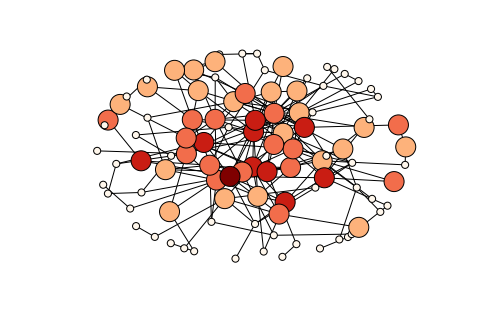

In [13]:
plt.clf()
display_kwargs = get_display_kwargs(g, infected_times)
vmin, vmax = np.min(display_kwargs['node_color']), np.max(display_kwargs['node_color'])
nx.draw(g, pos=pos, cmap='OrRd', **display_kwargs)
plt.savefig('figs/knk_full_obs.pdf')

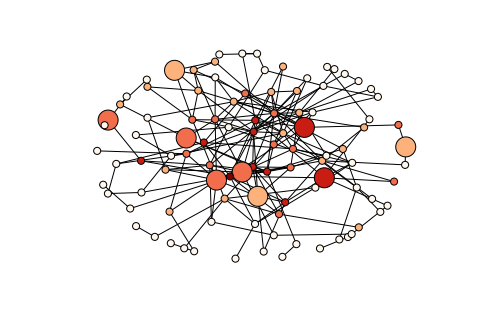

In [14]:
plt.clf()

diff = 1
upper_bound = np.max(list(infected_times.values())) + diff
node_colors = [((upper_bound - infected_times[n] + diff) if n in infected_times else 0)
               for n in g.nodes()]
node_sizes = [(400 if n in observed else 50)
              for n in g.nodes()]

nx.draw(g, pos=pos, cmap='OrRd', vmin=vmin, vmax=vmax,
        node_color=node_colors,
        node_size=node_sizes)

plt.savefig('figs/knk_partial_obs.pdf')

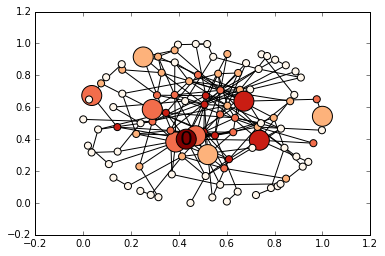

In [15]:
plt.clf()
node_sizes = [(400 
               if n in observed else
               (400 if n in queries else 50))
              for n in g.nodes()]

nx.draw_networkx_labels(g,
                        pos,
                        {q: i for i, q in enumerate(queries)},
                        font_size=20)
nx.draw_networkx_nodes(g,
                       pos=pos,
                       cmap='OrRd',
                       node_size=node_sizes,
                       node_color=node_colors)
nx.draw_networkx_edges(g.to_undirected(), pos)
plt.savefig('figs/knk_queries.pdf')

In [31]:
from joblib import Parallel, delayed
rows = Parallel(n_jobs=8)(delayed(run_simulation)(P_peri, 8, 512) for _ in range(100))

In [36]:
data = list(map(lambda t: (len(t[1]), len(t[3])), rows))

In [37]:
import pandas as pd
df = pd.DataFrame(data, columns=['csize', 'qsize'])

In [38]:
cs = df['csize'].describe()
qs = df['qsize'].describe()
rs = (df['qsize'] / df['csize']).describe()

stat = pd.DataFrame([cs.as_matrix(), qs.as_matrix(), rs.as_matrix()],
                    columns=rs.index,
                    index=['cascade size', 'query size', 'query size / cascade size'])


In [39]:
stat

,count,mean,std,min,25%,50%,75%,max
cascade size,100.0,63.540000,38.747674,11.000000,27.750000,58.500000,100.000000,134.0
query size,100.0,6.350000,4.445802,1.000000,3.000000,6.000000,9.000000,19.0
query size / cascade size,100.0,0.200265,0.290943,0.007812,0.039804,0.088651,0.198864,1.5


In [44]:
print(stat.to_string())

                           count       mean        std        min        25%        50%         75%    max
cascade size               100.0  63.540000  38.747674  11.000000  27.750000  58.500000  100.000000  134.0
query size                 100.0   6.350000   4.445802   1.000000   3.000000   6.000000    9.000000   19.0
query size / cascade size  100.0   0.200265   0.290943   0.007812   0.039804   0.088651    0.198864    1.5


In [20]:
print(stat.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &       mean &        std &        min &        25\% &        50\% &        75\% &         max \\
\midrule
cascade size              &  100.0 &  74.900000 &  39.219275 &  11.000000 &  33.000000 &  87.000000 &  109.00000 &  131.000000 \\
query size                &  100.0 &   5.900000 &   4.255715 &   1.000000 &   2.000000 &   5.000000 &    8.00000 &   17.000000 \\
query size / cascade size &  100.0 &   0.156832 &   0.242774 &   0.007634 &   0.033927 &   0.066708 &    0.14667 &    1.071429 \\
\bottomrule
\end{tabular}



In [ ]:
df.plot.scatter(x='csize', y='qsize')